In [1]:
import keras
from keras import layers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

2025-10-20 15:21:03.311880: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 10

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
val_split = 0.1

val_indices = int(len(x_train) * val_split)
new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]
x_val, y_val = x_train[:val_indices], y_train[:val_indices]

print(f"Training data samples: {len(new_x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")

Training data samples: 45000
Validation data samples: 5000
Test data samples: 10000


In [4]:
image_size = 32
auto = tf.data.AUTOTUNE

augmentation_layers = [
    keras.layers.RandomCrop(image_size, image_size),
    keras.layers.RandomFlip("horizontal"),
]


def augment_images(images):
    for layer in augmentation_layers:
        images = layer(images, training=True)
    return images


def make_datasets(images, labels, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(
            lambda x, y: (augment_images(x), y), num_parallel_calls=auto
        )
    return dataset.prefetch(auto)


train_dataset = make_datasets(new_x_train, new_y_train, is_train=True)
val_dataset = make_datasets(x_val, y_val)
test_dataset = make_datasets(x_test, y_test)

I0000 00:00:1760966470.765460    9084 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9128 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [5]:
def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)


def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)


def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x


def get_conv_mixer_256_8(
    image_size=32, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=10
):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


In [6]:
# Code reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/.


def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/tmp/checkpoint.keras"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model

In [7]:
conv_mixer_model = get_conv_mixer_256_8()
history, conv_mixer_model = run_experiment(conv_mixer_model)

Epoch 1/10


2025-10-20 15:21:17.059621: I external/local_xla/xla/service/service.cc:163] XLA service 0x74dd300021d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-20 15:21:17.059633: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-10-20 15:21:17.226886: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-20 15:21:18.188251: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


  4/352 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.1676 - loss: 2.2708

I0000 00:00:1760966481.162340    9192 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 65ms/step - accuracy: 0.4564 - loss: 1.4943 - val_accuracy: 0.1038 - val_loss: 3.9110
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - accuracy: 0.6981 - loss: 0.8528 - val_accuracy: 0.7328 - val_loss: 0.7573
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.7749 - loss: 0.6399 - val_accuracy: 0.7694 - val_loss: 0.7049
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.8243 - loss: 0.5035 - val_accuracy: 0.7770 - val_loss: 0.6812
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.8528 - loss: 0.4216 - val_accuracy: 0.8054 - val_loss: 0.6048
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.8804 - loss: 0.3483 - val_accuracy: 0.8036 - val_loss: 0.6112
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.8946 - loss: 0.3035 - val_accuracy: 0.8314 - val_loss: 0.5259
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.9119 - loss: 0.2559 - val_accurac

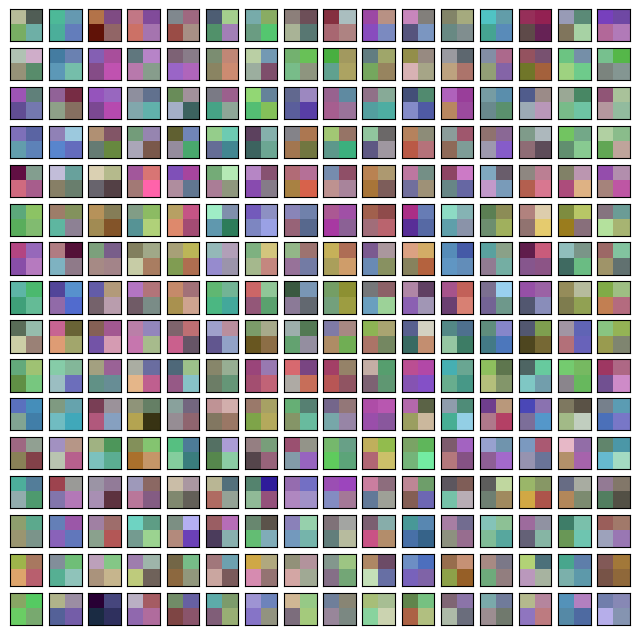

In [8]:
# Code reference: https://bit.ly/3awIRbP.


def visualization_plot(weights, idx=1):
    # First, apply min-max normalization to the
    # given weights to avoid isotrophic scaling.
    p_min, p_max = weights.min(), weights.max()
    weights = (weights - p_min) / (p_max - p_min)

    # Visualize all the filters.
    num_filters = 256
    plt.figure(figsize=(8, 8))

    for i in range(num_filters):
        current_weight = weights[:, :, :, i]
        if current_weight.shape[-1] == 1:
            current_weight = current_weight.squeeze()
        ax = plt.subplot(16, 16, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(current_weight)
        idx += 1


# We first visualize the learned patch embeddings.
patch_embeddings = conv_mixer_model.layers[2].get_weights()[0]
visualization_plot(patch_embeddings)

5 <DepthwiseConv2D name=depthwise_conv2d, built=True>
12 <DepthwiseConv2D name=depthwise_conv2d_1, built=True>
19 <DepthwiseConv2D name=depthwise_conv2d_2, built=True>
26 <DepthwiseConv2D name=depthwise_conv2d_3, built=True>
33 <DepthwiseConv2D name=depthwise_conv2d_4, built=True>
40 <DepthwiseConv2D name=depthwise_conv2d_5, built=True>
47 <DepthwiseConv2D name=depthwise_conv2d_6, built=True>
54 <DepthwiseConv2D name=depthwise_conv2d_7, built=True>


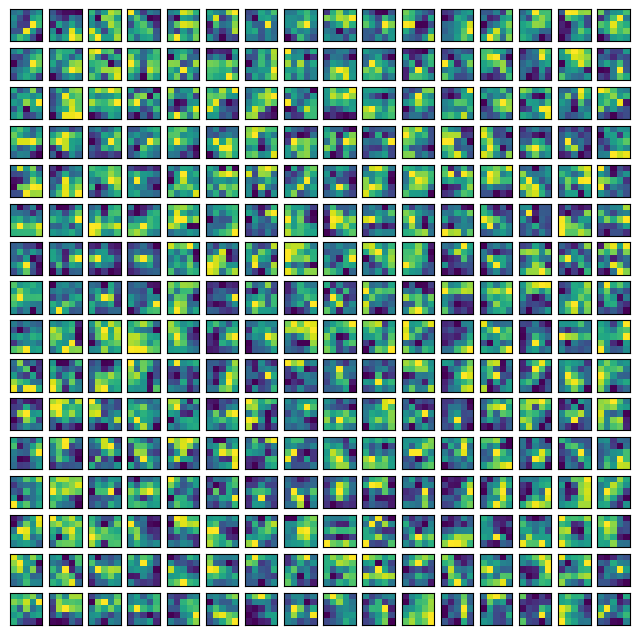

In [9]:
# First, print the indices of the convolution layers that are not
# pointwise convolutions.
for i, layer in enumerate(conv_mixer_model.layers):
    if isinstance(layer, layers.DepthwiseConv2D):
        if layer.get_config()["kernel_size"] == (5, 5):
            print(i, layer)

idx = 26  # Taking a kernel from the middle of the network.

kernel = conv_mixer_model.layers[idx].get_weights()[0]
kernel = np.expand_dims(kernel.squeeze(), axis=2)
visualization_plot(kernel)